In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# https://www.kaggle.com/datasets/yanmaksi/big-molecules-smiles-dataset?resource=download
df = pd.read_csv('SMILES_Big_Data_Set.csv')
df.head()

,SMILES,pIC50,mol,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.1591
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.6743
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.5361
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.9510
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.2130


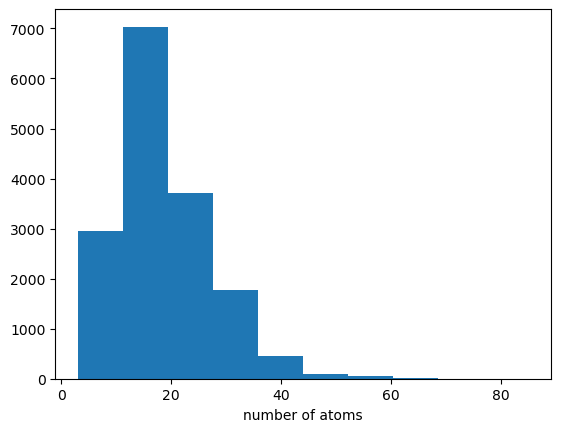

In [3]:
plt.hist(df['num_atoms'])
plt.xlabel('number of atoms')
plt.show()

In [14]:
# build one-hot encoder (list of lists)
def build_dict_list(split_string: str, smile_dict_list: list) -> list:
    for c in split_string:
        if c not in smile_dict_list:
            smile_dict_list.append(c)
    return smile_dict_list

def make_dict(smile_dict_list: list) -> dict:
    smile_dict = {}
    for i, c in enumerate(smile_dict_list):
        smile_dict[c] = i
    return smile_dict

def encoder(split_string: list, smile_dict: list, max_mol_len: int) -> list[list]:
    # print(split_string)

    encoded_smile = []
    for i, c in enumerate(split_string):
        if i < max_mol_len: # truncate if greater than max_mol_len
            one_hot = [0]*len(smile_dict)
            one_hot[smile_dict[c]] = 1
            encoded_smile.append(one_hot)

    # zero pad
    while len(encoded_smile) < max_mol_len:
        encoded_smile.append([0]*len(smile_dict))

    return encoded_smile

In [15]:
# training functions

# split test and train
def data_split(df, test_frac=0.2):
    ind = np.random.choice(len(df), size=int(test_frac*len(df)), replace=False)
    df_test = df.iloc[ind]
    df_train = df.drop(ind)
    return df_test.reset_index(), df_train.reset_index()

# sample without replacement
def data_sample(X, Y, batch_size=10):
    ind = np.random.choice(len(X), size=batch_size, replace=False)
    return X[ind], Y[ind]

In [16]:
def split_strings(smile_str: str) -> list:
    del_char = ['[',']']
    for d in del_char:
        smile_str = smile_str.replace(d,'')

    two_let_el = ['Cl','Br','Si','Se','se'] # two letter elements to check for

    mol_list = []
    skip = False
    for i,c in enumerate(smile_str):
        if not skip and i < len(smile_str)-1:
            potential_el = ''.join([smile_str[i],smile_str[i+1]])
            if potential_el in two_let_el:
                skip = True
                mol_list.append(potential_el)
            if not skip:
                mol_list.append(c)
        elif not skip and i == len(smile_str)-1:
            mol_list.append(c)
        else:
            skip = False

    return mol_list

In [17]:
# data preprocessing
max_mol_len = 40
df1 = df[df['num_atoms'] <= max_mol_len].dropna()
df2 = df1.reset_index()

# split test and train
df_test, df_train = data_split(df2[['SMILES', 'pIC50']])

# break strings into list of characters
ss_test = [split_strings(df_test['SMILES'][i]) for i in range(len(df_test))]
ss_train = [split_strings(df_train['SMILES'][i]) for i in range(len(df_train))]

# make list of unique characters for dict
smile_dict_list = []
for i in reversed(range(len(ss_train))):
    smile_dict_list = build_dict_list(ss_train[i], smile_dict_list)

# build dict
smile_dict = make_dict(smile_dict_list)
dict_len = len(smile_dict)
print(smile_dict)

# make one-hot encoding of molecules using dict
encoded_smile_train = [encoder(ss_train[i],smile_dict,max_mol_len) for i in range(len(ss_train))]
encoded_smile_test = [encoder(ss_test[i],smile_dict,max_mol_len) for i in range(len(ss_test))]

# convert data to torch tensor
x_train = torch.Tensor(encoded_smile_train)
y_train = torch.Tensor(df_train['pIC50'])
x_test = torch.Tensor(encoded_smile_test)
x_test = x_test.flatten(1)
y_test = torch.Tensor(df_test['pIC50'])

{'N': 0, '=': 1, '+': 2, 'C': 3, 'c': 4, '1': 5, '(': 6, 'O': 7, ')': 8, '-': 9, 'o': 10, 'S': 11, 'n': 12, 'H': 13, '2': 14, '3': 15, 'Cl': 16, 's': 17, '#': 18, 'Br': 19, 'I': 20, 'F': 21, '4': 22, 'P': 23, '5': 24, 'Se': 25, 'Si': 26, '6': 27, 'se': 28, '7': 29}


- what does nn.Module and super().__init__() do
    - including nn.Module allows model to inherit torch.nn.Module, which is required for storing layers and keeping track of gradients
    - including super().__init__() properly initializes nn.Module

future work
- use fc 2 layer MLP to compare
- use data loader for larger datasets
- try better way of smiles embeddings to handle rings, branching, etc

In [18]:
# model
class MLP(nn.Module):
    def __init__(self, max_mol_len, dict_len):
        super().__init__()
        self.fc1 = nn.Linear(max_mol_len*dict_len, int(max_mol_len*dict_len/2))
        self.fc2 = nn.Linear(int(max_mol_len*dict_len/2), 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        return x

In [19]:
# training loop

def train_loop(N_epochs, batch_size, lr):
    mlp_mod = MLP(max_mol_len, dict_len)
    optimizer = torch.optim.Adam(mlp_mod.parameters(), lr=lr)
    loss = nn.MSELoss()
    error = []
    error_test = []

    for _ in range(N_epochs):
        mlp_mod.train()

        x_sample, y_sample = data_sample(x_train, y_train, batch_size=batch_size)
        x_sample = x_sample.flatten(1) # adding in channel dimension

        y_pred = mlp_mod(x_sample)
        y_pred = y_pred.squeeze(1)

        optimizer.zero_grad()

        mseloss = loss(y_pred, y_sample)
        error.append(mseloss.item())
        mseloss.backward()
        optimizer.step()

        # evaluation
        mlp_mod.eval()
        y_pred = mlp_mod(x_test).squeeze(1)
        mseloss = loss(y_pred, y_test)
        error_test.append(mseloss.item())

    return error, error_test

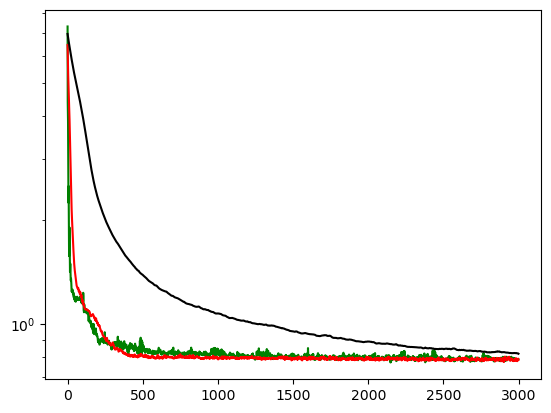

In [20]:
N_epochs = 3000
batch_size = 1000

lr = [1e-2, 1e-3, 1e-4]
col = ['g','r','k']
for i,l in enumerate(lr):
    error, error_test = train_loop(N_epochs, batch_size, lr=l)
    # plt.plot(range(N_epochs), error, color=col[i], linestyle='--')
    plt.plot(range(N_epochs), error_test, color=col[i])
plt.yscale('log')
plt.show()